In [32]:
%matplotlib inline
#load all the packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam



In [16]:
aapl=pd.read_csv('AAPL.csv')#read the data
data=aapl[['Dt', 'Adj Close', 'Close', 'High', 'Low', 'Open','Volume']] #identify important columns
data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,713.000000,713.000000,713.000000,713.000000,713.000000,7.130000e+02
mean,173.878959,177.649053,179.123754,176.057615,177.551905,2.996876e+07
std,29.175435,28.050142,28.436933,27.684636,28.055036,1.284490e+07
min,110.829700,116.020000,116.330000,114.760000,115.800000,1.136200e+07
25%,151.039600,155.900000,157.230000,154.480000,155.970000,2.120710e+07
50%,170.581200,174.670000,175.424000,173.250000,174.650000,2.642880e+07
75%,197.389800,199.250000,200.740000,198.010000,199.130000,3.476660e+07
max,248.304500,249.050000,249.750000,246.720000,248.970000,1.119850e+08


Text(0.5, 1.0, 'AAPLE share price')

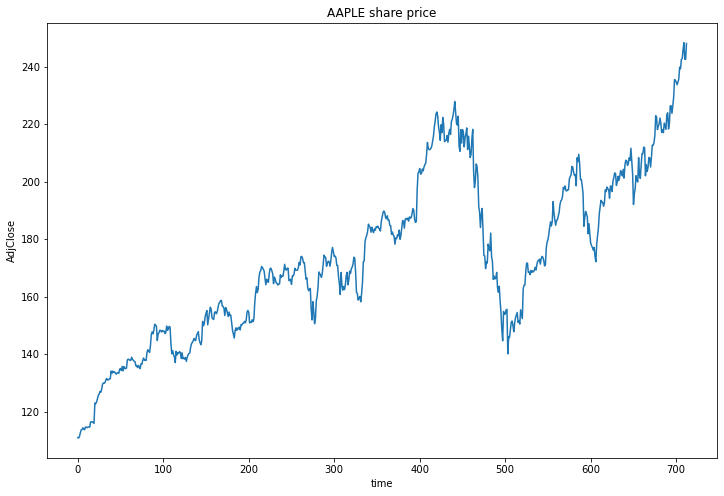

In [17]:
plt.figure(figsize=(12, 8)) #plotting the adjusted close price as it is a better representation of share price
data['Adj Close'].plot()
plt.xlabel('time')
plt.ylabel('AdjClose')
plt.title('AAPLE share price')

Text(0.5, 1.0, 'AAPLE share price')

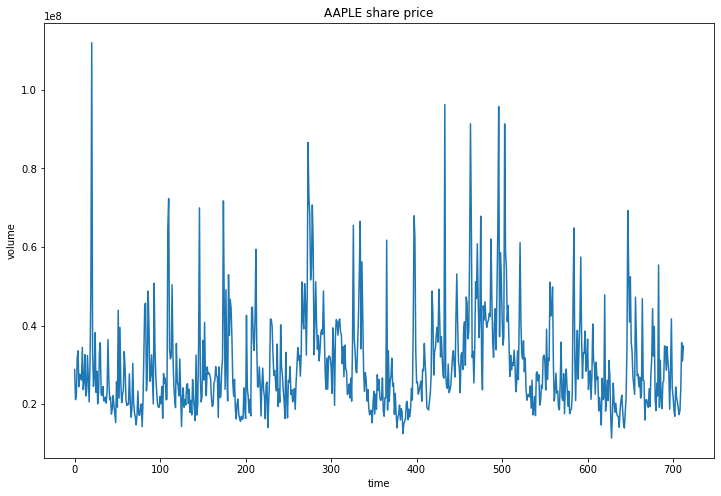

In [18]:
#plotting volume of share price to get an idea of variation
plt.figure(figsize=(12,8))
data['Volume'].plot() 
plt.xlabel('time')
plt.ylabel('volume')
plt.title('AAPLE share price')

C:\Users\anura\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'APPLE')

<Figure size 2880x720 with 0 Axes>

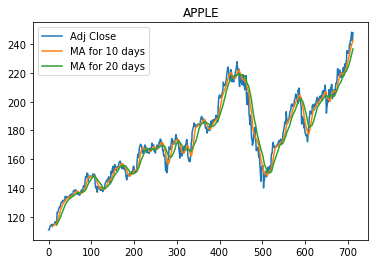

In [19]:
ma_day = [10, 20, 50] # plotting 10 day 20day and 50day moving average
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name]=data['Adj Close'].rolling(ma).mean()
data[column_name] = plt.figure(figsize=(40,10))
data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot().set_title('APPLE')

In [20]:
r=[0] # r is used to calculate daily return and it has n-1 fields it is initialized at 0 to make it compatible with the data frame
for i in range(data['Adj Close'].count()-1):
    r.append(((data['Adj Close'][i+1]-data['Adj Close'][i])/data['Adj Close'][i])*100)
data['return']=r

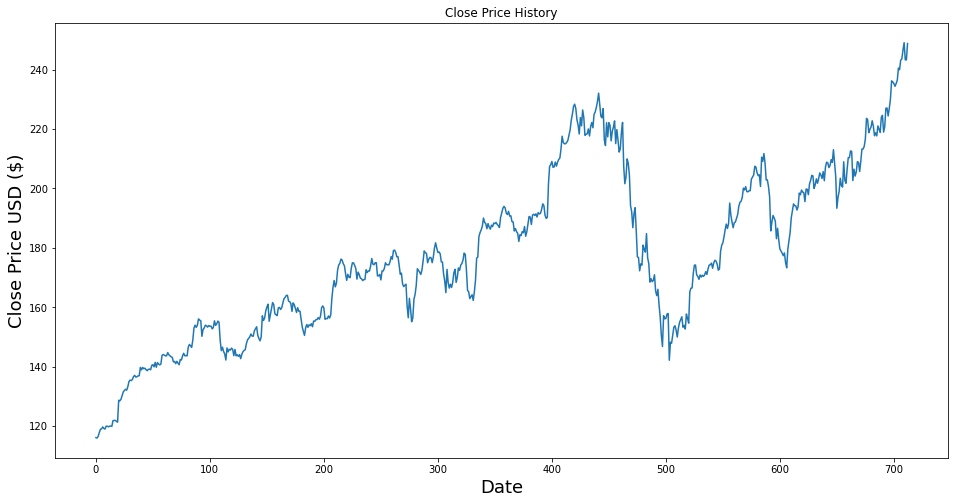

In [21]:
# plotting close price to identify if adjusted close price is better since it accounts for bonus and stock splits
plt.figure(figsize=(16,8))   
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [22]:
#root mean square error to calculate the model performance
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [23]:
#modelling the data on return as per question
stock=data['return']
#using min max scaler to scale the returns
scale=MinMaxScaler(feature_range=(0,1))
stock_scale=scale.fit_transform(np.array(stock).reshape(-1,1))

In [24]:
# since this is a time series we split the data first 80% is training and rest 20% is testing 
training_size=int(len(stock_scale)*0.8)
test_size=len(stock_scale)-training_size
train_data,test_data=stock_scale[0:training_size,:],stock_scale[training_size:len(stock_scale),:1]

In [25]:
# creating a numpy data matrix for training the NN
import numpy

def create_dataset(dataset,step=1):
    X, Y = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]   
        X.append(a)
        Y.append(dataset[i + step, 0])
    return numpy.array(X), numpy.array(Y)

In [26]:

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [27]:
# we reshape the data as is required by LSTM for training
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [28]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(100,1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='Adam', loss='mean_squared_error')
regressor.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [29]:
#model fitting
regressor.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)


Epoch 1/10
8/8 [==============================] - 2s 284ms/step - loss: 0.1397 - val_loss: 0.0067
Epoch 2/10
8/8 [==============================] - 1s 112ms/step - loss: 0.0380 - val_loss: 0.0094
Epoch 3/10
8/8 [==============================] - 1s 111ms/step - loss: 0.0317 - val_loss: 0.0085
Epoch 4/10
8/8 [==============================] - 1s 112ms/step - loss: 0.0275 - val_loss: 0.0073
Epoch 5/10
8/8 [==============================] - 1s 111ms/step - loss: 0.0237 - val_loss: 0.0067
Epoch 6/10
8/8 [==============================] - 1s 112ms/step - loss: 0.0222 - val_loss: 0.0073
Epoch 7/10
8/8 [==============================] - 1s 110ms/step - loss: 0.0209 - val_loss: 0.0062
Epoch 8/10
8/8 [==============================] - 1s 110ms/step - loss: 0.0188 - val_loss: 0.0068
Epoch 9/10
8/8 [==============================] - 1s 110ms/step - loss: 0.0223 - val_loss: 0.0091
Epoch 10/10
8/8 [==============================] - 1s 110ms/step - loss: 0.0214 - val_loss: 0.0061


In [30]:
# accuracy prediction
test_predict=regressor.predict(X_test)
test_predict=scale.inverse_transform(test_predict)


In [34]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    X_hold = pd.read_csv(test_dir)
    
    predictions = model.predict(X_hold[301:])
    ids = X_hold.index[301:]
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = regressor # CHANGE None to your model !

saveModel(my_model, model_path)
holdout_dir = os.path.join(".", "Data","Holdout")

MyModel(holdout_dir, model_path)

Directory .\final_model already exists, files will be over-written.
Model saved in directory .\final_model; create an archive of this directory and submit with your assignment.


FileNotFoundError: [Errno 2] No such file or directory: '.\\Data\\Holdout'

In [ ]:
print("Done")